In [6]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
import torch.distributions as D

import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from data import *
from models import *

eps = np.finfo(float).eps

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(256, 1)

    def forward(self, x):
        mu = self.fc(x)
        return mu
    
def init_normal(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight)
        m.bias.data.fill_(0.001)

In [21]:
def kl_loss_funct(mu_i, std_i, mu_j, std_j):
    
    p_i = D.independent.Independent(D.normal.Normal(mu_i, std_i), 1)
    p_j = D.independent.Independent(D.normal.Normal(mu_j, std_j), 1)

    z_i = p_i.rsample()
    z_j = p_j.rsample()

    kl_1_2 = p_i.log_prob(z_i) - p_j.log_prob(z_i)
    kl_2_1 = p_j.log_prob(z_j) - p_i.log_prob(z_j)
    
    kl_loss = (kl_1_2 + kl_2_1).mean() / 2
    return kl_loss

def theoretical_kl(mu_i, std_i, mu_j, std_j):
    kl = np.log(std_j / std_i) + (std_i ** 2 + (mu_i - mu_j) ** 2) / (2 * std_j ** 2) - 0.5
    return kl

In [161]:
def simulate():
    mu1 = 0.
    mu2 = 0.5
    std1 = 1.
    std2 = 1.5

    x_i = torch.randn(32, 1, 256)
    x_j = (x_i + mu2) * std2

    mi = 1/2 *(np.log(1. + ( 1/(std2 ** 2) )))
    kl = np.log(std2 / std1) + (std1 ** 2 + (mu1 - mu2) ** 2) / (2 * std2 ** 2) - 0.5

#     print('The theoretical mi: {}'.format(mi))
#     print('The theoretical kl: {}'.format(kl))
    kl0 = kl

    mu_i = torch.mean(x_i, 2)
    std_i = torch.std(x_i, 2)

    mu_j = torch.mean(x_j, 2)
    std_j = torch.std(x_j, 2)

    kl1 = kl_loss_funct(mu_i, std_i, mu_j, std_j)
#     print('The kl func: {}'.format(kl1))

    model = SimpleNet()
    model.apply(init_normal)

    mu_i = model(x_i).detach().squeeze(1)
    mu_j = model(x_j).detach().squeeze(1)

    kl2 = kl_loss_funct(mu_i, std_i, mu_j, std_j)
#     print('The kl model func: {}'.format(kl2))
    return kl0, kl1, kl2

all_kl0 = []
all_kl1 = []
all_kl2 = []
for _ in range(1000):
    kl0, kl1, kl2 = simulate()
    all_kl0.append(kl0)
    all_kl1.append(kl1)
    all_kl2.append(kl2)

/Users/Maurits/Development/virtual_env/ML/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/Maurits/Development/virtual_env/ML/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


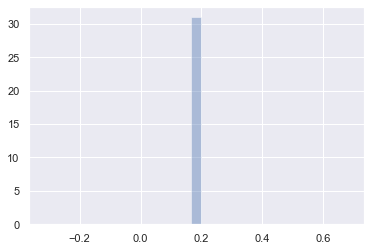

In [162]:
sns.distplot(all_kl0)

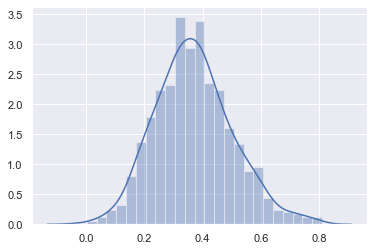

In [163]:
sns.distplot(all_kl1)

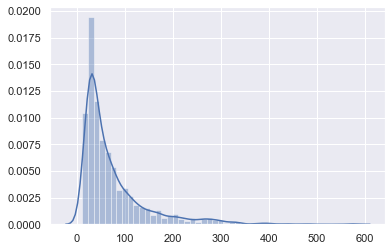

In [164]:
sns.distplot(all_kl2)

In [168]:
mu1 = 0.
mu2 = 0.5
std1 = 1.
std2 = 1.5

mi = 1/2 *(np.log(1. + ( 1/(std2 ** 2) )))
kl = np.log(std2 / std1) + (std1 ** 2 + (mu1 - mu2) ** 2) / (2 * std2 ** 2) - 0.5

print('True kl: {}'.format(kl))

True kl: 0.18324288588594217


In [170]:
model = SimpleNet()
model.apply(init_normal)
n_epoch = 1500

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

kl_hist = []
true_kl = []
for epoch in range(n_epoch):

    mu1 = 0.
    mu2 = 0.5
    std1 = 1.
    std2 = 1.5

    x_i = torch.randn(32, 1, 256)
    x_j = (x_i + mu2) * std2
    
    mu_i = model(x_i).squeeze(1)
    mu_j = model(x_j).squeeze(1)
    
    std_i = torch.std(x_i, 2)
    std_j = torch.std(x_j, 2)

    kl2 = kl_loss_funct(mu_i, std_i, mu_j, std_j)

    model.zero_grad()
    kl2.backward()
    optimizer.step()
    
    # theoretical kl
    
    kl = np.log(std_j.mean() / std_i.mean()) + (std_i.mean() ** 2 + (mu_i.mean() - mu_j.mean()) ** 2) / (2 * std_j.mean() ** 2) - 0.5
    
    true_kl.append(kl.item())
    kl_hist.append(kl2.item())


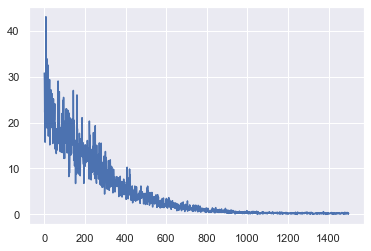

In [171]:
sns.set()
plt.plot(kl_hist)

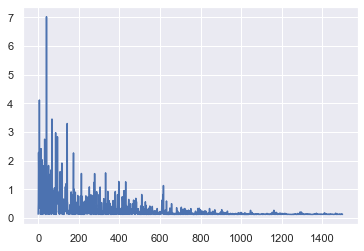

In [172]:
sns.set()
plt.plot(true_kl)

In [173]:
print(true_kl[-1])

0.1351606845855713


### CIFAR testing

In [4]:
use_cuda = True

if use_cuda:
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda")
    torch.cuda.set_device(0)
    print('GPU')
else:
    dtype = torch.FloatTensor
    device = torch.device("cpu")

GPU


In [31]:
# Datasets
train_transforms = cifar_train_transforms()
test_transforms = cifar_test_transforms()
target_transforms = None

loader = Loader('CIFAR10C', 'data', True, 8, train_transforms, test_transforms, None, use_cuda)
train_loader = loader.train_loader

Files already downloaded and verified
Files already downloaded and verified


In [32]:
def kl_loss_funct(mu_i, std_i, mu_j, std_j):
    
    p_i = D.independent.Independent(D.normal.Normal(mu_i, std_i), 1)
    p_j = D.independent.Independent(D.normal.Normal(mu_j, std_j), 1)

    z_i = p_i.rsample()
    z_j = p_j.rsample()

    kl_1_2 = p_i.log_prob(z_i) - p_j.log_prob(z_i)
    kl_2_1 = p_j.log_prob(z_j) - p_i.log_prob(z_j)
    
    kl_loss = (kl_1_2 + kl_2_1).mean() / 2
    return kl_loss

def theoretical_kl(mu_i, std_i, mu_j, std_j):
    kl = np.log(std_j / std_i) + (std_i ** 2 + (mu_i - mu_j) ** 2) / (2 * std_j ** 2) - 0.5
    return kl

In [39]:
model = SimpleFeatureEncoderNet().type(dtype)
model.apply(init_normal)
n_epoch = 4
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

kl_hist = []
true_kl = []
all_diff = []
for epoch in range(n_epoch):
    print("Epoch {}".format(epoch))
    for i, (x_i, x_j, _) in enumerate(train_loader):

        x_i = x_i.cuda() if use_cuda else x_i
        x_j = x_j.cuda() if use_cuda else x_j

        _, mu_i, std_i = model(x_i)
        _, mu_j, std_j = model(x_j)
        
        diff = torch.abs(mu_i - mu_j)
        diff = diff.view(-1, 1).mean()
        all_diff.append(diff.cpu().detach().numpy())

        std_i = torch.zeros_like(mu_i) + 0.2023
        std_j = torch.zeros_like(mu_i) + 0.2023
        
        std_i = std_i.cuda() if use_cuda else std_i
        std_j = std_j.cuda() if use_cuda else std_j
        
        kl2 = kl_loss_funct(mu_i, std_i, mu_j, std_j)

        model.zero_grad()
        kl2.backward()
        optimizer.step()

        # theoretical kl
        kl = theoretical_kl(mu_i.mean().cpu().detach().numpy(), std_i.mean().cpu().detach().numpy(), 
                            mu_j.mean().cpu().detach().numpy(), std_j.mean().cpu().detach().numpy())

        true_kl.append(kl.item())
        kl_hist.append(kl2.item())


Epoch 0
Epoch 1
Epoch 2
Epoch 3


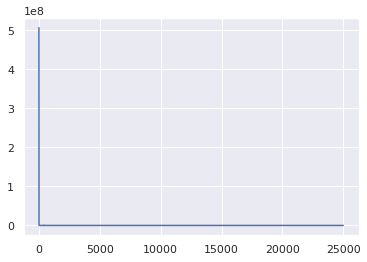

In [40]:
sns.set()
plt.plot(kl_hist)

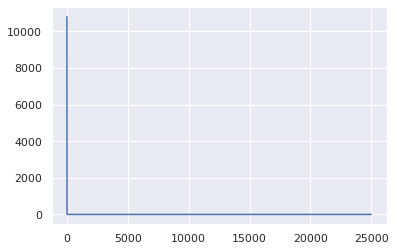

In [41]:
sns.set()
plt.plot(true_kl)

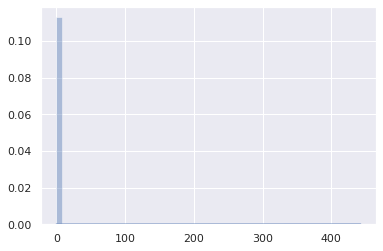

In [42]:
sns.set()
sns.distplot(all_diff)

In [43]:
all_diff = []
for i, (x_i, x_j, _) in enumerate(train_loader):

    diff = torch.abs(x_i - x_j)
    diff = diff.view(-1, 1).mean()
    all_diff.append(diff)

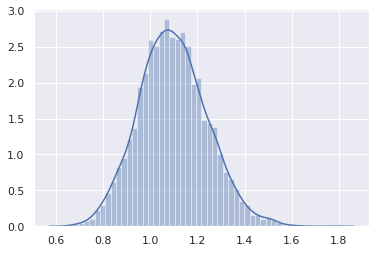

In [44]:
sns.distplot(all_diff)